In [1]:
import numpy as np
import cv2
import os
import keras
import tensorflow as tf
from skimage.io import imread


In [2]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Import And Prepare The Data

In [4]:
# !unzip /gdrive/MyDrive/CelebAMask-HQ/skindataset.zip

In [4]:
IMAGES_PATH = 'Skin-DataSet/Images'
MASKS_PATH = 'Skin-DataSet/Masks'
IMW,IMH = 256,256

In [6]:
img1 = cv2.resize(imread(os.path.join(IMAGES_PATH,'0.jpg')),(512,512))
img1_mask = imread(os.path.join(MASKS_PATH,'0.png'))

In [7]:
print(img1.shape)
print(img1_mask.shape)

(512, 512, 3)
(512, 512, 3)


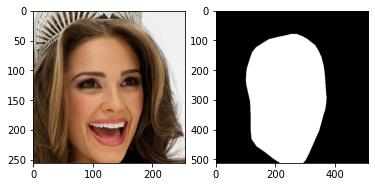

In [8]:
import matplotlib.pyplot as plt
plt.subplot(121)
plt.imshow(cv2.resize(img1,(IMW,IMH),interpolation=cv2.INTER_CUBIC))
plt.subplot(122)
plt.imshow(img1_mask)


In [9]:
tempidx = []
with open('Skin_indices.txt') as file:
  for line in file.readlines():
    idx = int(line)
    tempidx.append(idx)

In [10]:
from os.path import join

In [11]:
sample = 9500
error=0
images,masks = np.ones((sample,IMW,IMH,1),dtype=np.float16),np.ones((sample,IMW,IMH,1),dtype=np.float16)
for i,idx in enumerate(tempidx):
  if i <sample:
    image,mask = (
        cv2.resize(imread(join(IMAGES_PATH,f'{idx}.jpg'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC),
        cv2.resize(imread(join(MASKS_PATH,f'{idx}.png'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC)
    )
    images[i] = image.reshape((IMW,IMH,1))
    masks[i]= mask.reshape((IMW,IMH,1))
  else:
    break
  

In [12]:
print(len(os.listdir('/content/Skin-DataSet/Images/')))

12476


# Build  Model

In [13]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, LambdaCallback
from keras import regularizers
import keras

In [14]:
def get_model():
  keras.backend.clear_session()
  inputs = Input((IMW, IMH, 1))
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
  conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
  conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
  conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
  conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
  conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
  poo5a = MaxPooling2D(pool_size=(2, 2))(conv5)
  conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(poo5a)
  conv5a = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5a)
  up6a = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5a), conv5], axis=3)
  conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(up6a)
  conv6a = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6a)
  up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
  conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
  up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
  conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)
  up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
  conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
  up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
  conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)
  conv10 = Conv2D(1, (3, 3), activation='relu', padding='same')(conv9)
  return Model(inputs=[inputs], outputs=[conv10])


In [15]:
model = get_model()

In [16]:
opt = tf.keras.optimizers.SGD(learning_rate=5e-3,momentum=0.9)
model.compile(optimizer=opt, loss='mse', metrics=['acc'])
# model.summary()

In [17]:
import json
json_log = open('history.json', mode='wt', buffering=1)
json_logging_callback = LambdaCallback(
    on_epoch_end=lambda epoch, logs: json_log.write(
        json.dumps({'epoch': epoch, 'loss': logs['loss'],'val_loss': logs['val_loss'],'acc': logs['acc'],'val_acc': logs['val_acc']}) + '\n'),
    on_train_end=lambda logs: json_log.close()
)

In [18]:
epochs = 25
callbacks = [
    ModelCheckpoint("Skin-Segmintaion.h5", save_best_only=True),
    json_logging_callback,
]
history = model.fit(images,masks,validation_split=0.2,epochs=epochs,batch_size=24,callbacks=callbacks)


Epoch 1/25
317/317 [==============================] - 179s 500ms/step - loss: 0.1887 - acc: 0.6603 - val_loss: 0.1817 - val_acc: 0.7100
Epoch 2/25
317/317 [==============================] - 152s 480ms/step - loss: 0.1689 - acc: 0.7237 - val_loss: 0.1732 - val_acc: 0.7179
Epoch 3/25
317/317 [==============================] - 152s 480ms/step - loss: 0.1636 - acc: 0.7350 - val_loss: 0.1650 - val_acc: 0.7349
Epoch 4/25
317/317 [==============================] - 152s 479ms/step - loss: 0.1541 - acc: 0.7543 - val_loss: 0.1461 - val_acc: 0.7749
Epoch 5/25
317/317 [==============================] - 152s 478ms/step - loss: 0.1325 - acc: 0.7959 - val_loss: 0.1308 - val_acc: 0.8082
Epoch 6/25
317/317 [==============================] - 151s 478ms/step - loss: 0.0868 - acc: 0.8729 - val_loss: 0.0570 - val_acc: 0.9142
Epoch 7/25
317/317 [==============================] - 152s 478ms/step - loss: 0.0556 - acc: 0.9170 - val_loss: 0.0521 - val_acc: 0.9219
Epoch 8/25
317/317 [============================

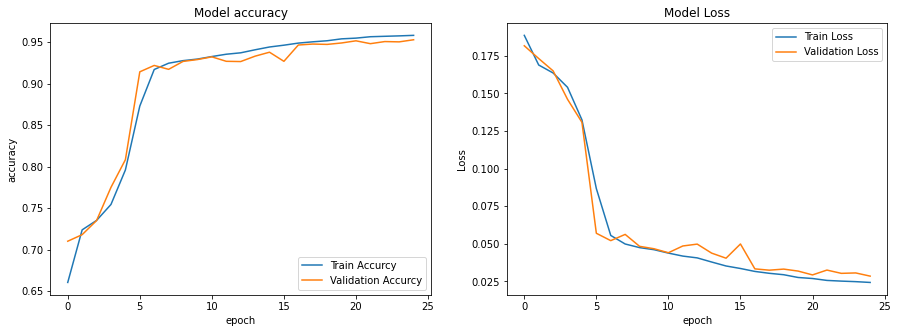

In [19]:
h = history
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(h.history['acc'],label='Train Accurcy')
plt.plot(h.history['val_acc'],label='Validation Accurcy')
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.subplot(122)
plt.plot(h.history['loss'],label='Train Loss')
plt.plot(h.history['val_loss'],label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Save Model & History

In [20]:
import json
model.save('/gdrive/MyDrive/Skin-Model-E25LR0_005M0_9.h5')
with open('/gdrive/MyDrive/SkinModelHistory.json', 'w') as file_pi:
  json.dump(history.history, file_pi)

# Evaluate

In [11]:
model = tf.keras.models.load_model('/gdrive/MyDrive/Skin-Model-E25LR0_005M0_9.h5')


In [12]:
import random
sample = 2476
TestImages,TestMasks = np.ones((sample,IMW,IMH,1)),np.ones((sample,IMW,IMH,1))
for i,idx in enumerate(tempidx[-sample:]):
  TestImages[i] = cv2.resize(imread(join(IMAGES_PATH,f'{idx}.jpg'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))
  TestMasks[i] = cv2.resize(imread(join(MASKS_PATH,f'{idx}.png'),as_gray=True),(IMW,IMH),interpolation=cv2.INTER_CUBIC).reshape((IMW,IMH,1))


In [13]:
score = model.evaluate(TestImages,TestMasks)
score

78/78 [==============================] - 33s 213ms/step - loss: 0.0278 - acc: 0.9535


[0.02783207781612873, 0.9535472393035889]

# Predection

In [14]:
def predict(image):
    return model.predict(np.asarray([image]) ).reshape((IMW,IMH))

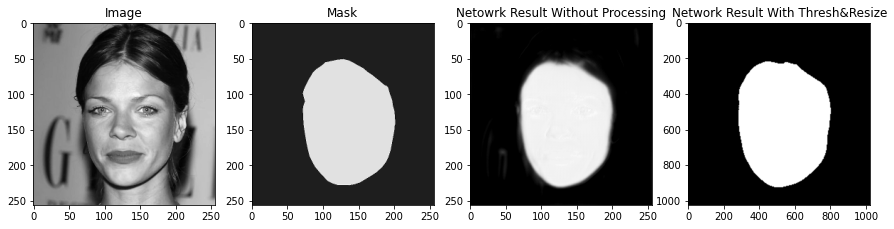

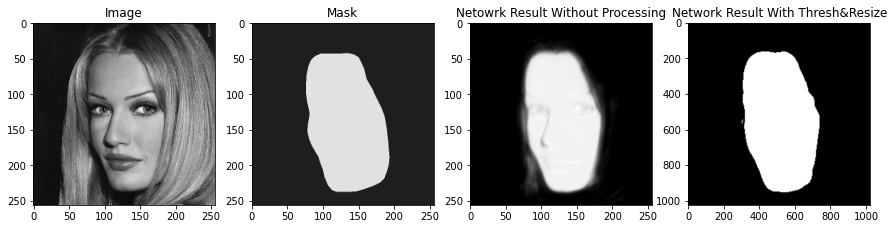

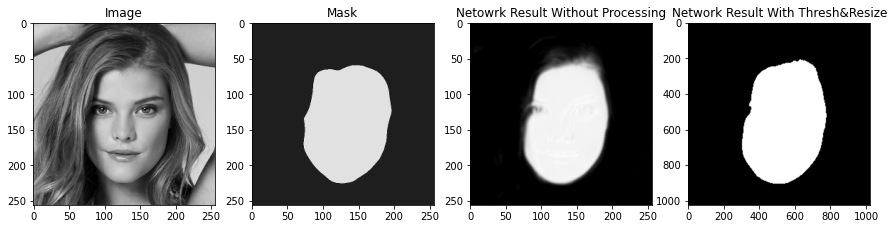

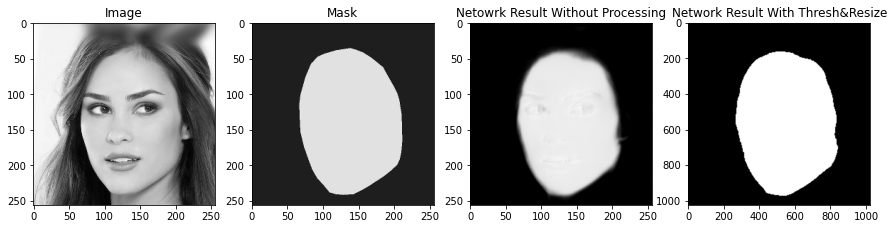

In [20]:
for idx in random.choices(range(len(TestImages)),k=4):
    res = predict(TestImages[idx])
    plt.figure(figsize=(15,5))
    plt.subplot(141)
    plt.imshow(TestImages[idx].reshape((IMW,IMH)),'gray')
    plt.title('Image')
    plt.subplot(142)
    plt.imshow(TestMasks[idx].reshape((IMW,IMH)),'gray')
    plt.title('Mask')
    plt.subplot(143)
    plt.imshow(res.copy(),'gray')
    plt.title('Netowrk Result Without Processing')
    plt.subplot(144)
    res = cv2.normalize(res, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    res = cv2.threshold(res.reshape((IMW,IMH,1)),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    plt.imshow(cv2.resize(res,(1024,1024),interpolation=cv2.INTER_CUBIC),'gray')
    plt.title('Network Result With Thresh&Resize')